# Chapter 11. Route Planning A 
---------------------------------------------


In [6]:
%matplotlib inline
from IPython.core.pylabtools import figsize
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import random
import numpy.linalg
from ipywidgets import *
from IPython.display import display
from IPython.core.display import HTML
from notebook.nbextensions import enable_nbextension 


def css_styling():
    styles = open("../styles/custom.css", "r").read()
    return HTML(styles)
css_styling()



### Comments

Stochastic dynamic programming is a methodology for making sequential decisions in the face of uncertainty.  Route planning is a simple but intuitive example.  Controlling a Markov chain is a more general class of examples called Markov Decision Problems.


## 11.1 Markov Decision Problems

Consider the random sequence $\{X_n, n \geq 0\}$ that takes values in some discrete set ${\cal X}$ and is such that 

$$P[X_{n+1} = j \mid X_n = i, a_n = a] = P(i,j;a), \mbox{ for }a \in {\cal A}(i) \mbox{ and } i, j \in {\cal X}, $$

where ${\cal A}(i)$ is a set of possible values of $a_n$ when $X_n = i$.

Thus, $X_n$ behaves like a Markov chain, except that its transition probabilities are "controlled" by the actions $a_n$. The goal is to choose the actions $a_n$ to minimize some expected cost that we define next.

The simplest formulation is to minimize

$$\sum_{n=0}^N E[c(X_n, a_n)]$$

where $c(\cdot, \cdot)$ is a given function that represents the cost of taking action $a_n$ when the state
is $X_n$.  The main observation is that it is generally not best to be greedy and choose the value of $a_n$
that minimizes $c(X_n, a_n)$.  The reason is that a more expensive action $a_n$ might result in a preferable
subsequent state $X_{n+1}$.  Thus, short term sacrifices may result in larger overall returns, like going to college.

Bellman's breakthrough is to define $V_N(x)$ as the minimum value of that cost given that $X_0 = x$.  The minimum is over the possible choices of the actions as a function of the state and the number of steps to go.  With this definition, one has

$$V_{N+1}(x) = \min_{a \in {\cal A}(x)} [c(x, a) + \sum_y P(x,y;a)V_N(x)].$$

When $N \to \infty$, it may be that $V_N(x) \to V(x)$ that then satisfies

$$V(x) = \min_{a \in {\cal A}(x)} [c(x, a) + \sum_y P(x,y;a)V(x)].$$

This is the case if, for instance, the Markov chain gets absorbed after a finite mean time in some state where the cost is zero.

A small variation is when we consider the discounted cost

$$\sum_{n=0}^N E[\beta^n c(X_n, a_n)]$$

where $\beta \in (0, 1)$ is a discount factor.  We then define $V_N(x; \beta)$ as the minimum value of the cost starting with $X_0 = x$ and one has

$$V_{N+1}(x; \beta) = \min_{a \in {\cal A}(x)} [c(x, a) + \beta \sum_y P(x,y;a)V_N(x; \beta)].$$

If the cost $c(\cdot, \cdot)$ is bounded, then the cost remains finite as $N \to \infty$.  In that case,
$V_N(x; \beta) \to V(x; \beta)$ and this limit is such that

$$V(x; \beta) = \min_{a \in {\cal A}(x)} [c(x, a) + \beta \sum_y P(x,y;a)V(x; \beta)].$$

In some cases, one may consider a continuous state space.  We will see this in examples.  


## 11.2 Example 1: How to Gamble, If you Must

(We borrow the subtitle of a nice book by Dubbins and Savage.) 

You play a game of chance. You start with $M$ dollars.  At each step you choose how much to gamble.  If you gamble $a$, you win $a$ with probability $p$ and you lose $a$ otherwise.  Thus, if your fortune is $x$ and you gamble $a \leq x$, after that step, your fortune is $x + a$ with probability $p$ and $x - a$ with probability $q = 1 - p$.  You cannot gamble more than your current fortune.  Your goal is to maximize the probability that your fortune reaches $F$ for some given $F \geq M$ before your fortune reaches $0$.

How much should you gamble when your fortune is $x$?

Let $V(x)$ be the maximum probability of reaching $F$ before $0$, starting with a fortune equal to $x$.  Then, the DPEs are

$$V(x) = \max_{a \leq x} [pV(x + a) + qV(x - a)].$$

Also, $V(0) = 0$ and $V(F) = 1$.  The value $a(x)$ of $a$ that achieves the maximum is the optimal amount to gamble when the fortune is $x$.


**Theorem:**

If $p \geq 0.5$, then $a(x) = 1$ for all $x$ is optimal.  One says that **timid play is optimal** when the game is favorable.

**Proof:**

Let $U(x)$ be the probability of hitting $F$ before $0$ starting from $x$ when choosing $a(x) = 1$ for all $x$.  Then, the first step equations are

$$U(x) = pU(x+1) + qU(x-1), 1 \leq x \leq F; U(0) = 0, U(F) = 1.$$

For $p \neq q$, the solution can be verified to be 

$$U(x) = \frac{ 1- (q/p)^x}{1 - (q/p)^F}.$$

Also, when $p > 0.5$, we claim that

$$U(x) = pU(x+1) + qU(x-1) \geq pU(x + a) + qU(x - a), a \in \{1, 2, \ldots, x\}.$$

To see this, note that the expression for $U(x)$ shows that this inequality is equivalent to 

$$1 = p(q/p) + q(q/p)^{-1} \leq p(q/p)^a + q(q/p)^{-a}.$$

Now, $h(x) := (1/x - 1)^a$ is convex in $x$, which implies that $ph(p) + qh(q) \geq h((p+q)/2) = 1$.

This shows that $U$ satisfies the DPE and also that $a(x) = 1$ is optimal.

Unfortunately, the optimal strategy when $p < 0.5$ is more complicated.  We compute it below.

**Notes:** 

* Be patient with the computation when you more the cursors.

* For clarity, we plot $V(x) \times \max_y \{a(y)\}$ instead of $V(x)$.

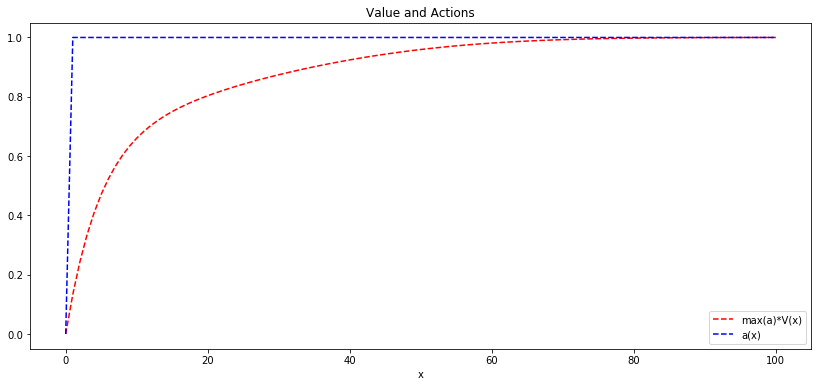

In [7]:
%matplotlib inline
from IPython.core.pylabtools import figsize
import numpy as np
from matplotlib import pyplot as plt
import random
from ipywidgets import *
from IPython.display import display

def MDP1(p,F):  # How to gamble if you must
    t = np.arange(0,F+1)
    a = np.arange(0.0,F+1)
    V = np.arange(0.0,F+1)
    W = np.arange(0.0,F+1)
    q = 1 - p
    
    
    for x in range(F+1):  # initialize V
        V[x] = (x == F) 
    S = 3*F
    W[F] = 1
    a[F] = 1
    for s in range(S):
        for x in range(1,F): # W = max_{1 <= u <= x} [p*V[x+u] + q*V[x-u]]
            y = 0.0           
            for u in range(1,x+1):
                z = p*V[min(F,x+u)] + q*V[x-u]
                if z > y + 0.01:
                    a[x] = u
                    y = z
            W[x] = y
        V = W
        
    plt.figure(figsize = (14,6))
    pltV, = plt.plot(t,max(a)*V,'r--',label='max(a)*V(x)')
    plt.legend()
    pltV, = plt.plot(t,a,'b--',label='a(x)')
    plt.legend()
    plt.title('Value and Actions')
    plt.xlabel('x')
        


u1 = widgets.FloatSlider(description='p', min = 0.0, max = 1, step = 0.05, value = 0.5)
u2 = widgets.IntSlider(description='F', min = 10, max = 200, step = 1, value = 100)
        
z = widgets.interactive(MDP1, p = u1, F = u2,continuous_update=False) 
display(z)
        

## 11.3 Example 2: Simplified Farkle

Farkle is a dice game where players take turns and can roll the dice multiple times to increase their score but risk not scoring on their round if they push their luck too hard.  

The optimal strategy for Farkle is complex, as one player should base his/her choices on the scores of the other players.  Here, we model a highly simplified version of the game with two players and a biased coin such that $P(H) = p$.  We compute the optimal strategy.  The key point of the model is that the amount of risk a player takes should depend on both scores. 

In our game, a player has a coice of flipping the coin once and get $1$ for $H$ and $0$ for $T$, or to flip the coin twice and get $3$ for $HH$ and $0$ otherwise.  Thus, a player can be timid or bold. The two players take turns and the first one to $F$ wins.

Let $(x, y)$ be the current scores of the two players and assume it is player $1$'s turn to play.  Let $V(x,y)$ be his maximum probability of winning the game. Then the DPEs are

\begin{eqnarray*}
&& V(x,y) = \max\{p(1 - V(y,x+1)) + (1 - p)(1 - V(y,x)), p^2(1 - V(y,x+3)) + (1 - p^2)(1 - V(y,x))\}, x \leq F-3, y \leq F-1\\
&& V(F-2,y) = \max\{p(1 - V(y,F-1)) + (1 - p)(1 - V(y,F-2)), p^2 + (1 - p^2)(1 - V(y,F-2))\}, y \leq F-1\\
&& V(F-1,y) = p + (1 - p)(1 - V(y,F-1)).
\end{eqnarray*}
The boundary conditions are $V(F,x) = 1$ and $V(x, F) = 0$ for $x < F$.   

These equations are of the form $V = f(V)$.  To solve them, we iterate $V_{n+1} = f(V_n)$, starting with $V_0(x,y) = 1\{x = F, y < F\}$.   After solving, we look at the DPEs to determine the winning strategy.
Qualitatively, that strategy is "be timid when ahead and bold when behind."


In plots below, x is vertical and y is horizontal
Top graph: winning Strategy: once if red; twice if green
Bottom graph: V(x,y)


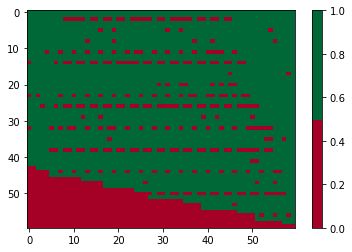

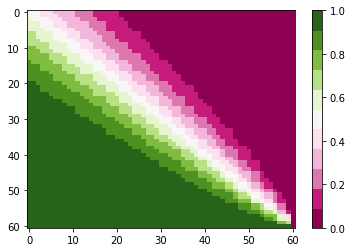

In [42]:
%matplotlib inline
from IPython.core.pylabtools import figsize
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
import random
from ipywidgets import *
from IPython.display import display

def MDP2(p,F):  # Simplified Farkle
    a = np.zeros((F,F))
    V = np.zeros((F+1,F+1))
    
    
    for x in range(F+1):  # initialize W
        for y in range(F+1):
            V[x,y] = (x == F)*(y < F) 
    
    S = 200
    for s in range(S):
        for y in range(F):
            for x in range(F-2):
                z1 = p*(1 - V[y,x+1]) + (1 - p)*(1 - V[y,x])
                z2 = p**2*(1 - V[y,x+3]) + (1 - p**2)*(1 - V[y,x])
                V[x,y] = max(z1,z2)
                a[x,y] = (z1 <= z2)
            z1 = p*(1 - V[y,F-1]) + (1 - p)*(1 - V[y,F-2])
            z2 = p**2 + (1 - p**2)*(1 - V[y,F-2])
            V[F-2,y] = max(z1,z2)
            a[F-2,y] = (z1 <= z2)
            V[F-1,y] = p + (1-p)*(1 - V[y,F-1])
            

    cmap = plt.cm.jet
    cmap1 = cm.get_cmap('RdYlGn', 2)
    #cmap1 = cm.get_cmap('PiYG', 2) 
    cmap2 = cm.get_cmap('PiYG', 11)
    print('In plots below, x is vertical and y is horizontal')
    print('Top graph: winning Strategy: once if red; twice if green')
    print('Bottom graph: V(x,y)')
    plt.figure(1)    
    plt.imshow(a, aspect='auto', interpolation='none',
               cmap = cmap1)
    plt.colorbar()
    
    plt.figure(2)
    plt.imshow(V, aspect='auto', interpolation='none',
              cmap = cmap2)
    plt.colorbar()   


u1 = widgets.FloatSlider(description='p', min = 0.0, max = 1, step = 0.05, value = 0.5)
u2 = widgets.IntSlider(description='F', min = 10, max = 100, step = 5, value = 60)
        
z = widgets.interactive(MDP2, p = u1, F = u2, continuous_update=False) 
display(z)
        